In [39]:
import srt_util
import matplotlib.pyplot as plt
import numpy as np
import PhysicsTool as pt

In [40]:
def normalize_spectrum(spec: np.ndarray) -> np.ndarray:
    """ Normalize a power spectrum by its maximum value. """
    spec = spec - min(spec)
    spec = spec / max(spec)
    return spec

def plot_sun_scan(hor_file_path: str, ver_file_path: str):
    with srt_util.SRT_HDF_Reader(hor_file_path) as srt_reader:
        offset = srt_reader.get_object_positions()['CenterH']
        spec = normalize_spectrum(srt_reader.get_power_spectrum().sum(axis=1))
        plt.scatter(offset, spec, label = 'Horizontal scan', marker='x')
    with srt_util.SRT_HDF_Reader(ver_file_path) as srt_reader:
        offset = srt_reader.get_object_positions()['CenterV']
        spec = spec = normalize_spectrum(srt_reader.get_power_spectrum().sum(axis=1))
        plt.scatter(offset, spec, label = 'Vertical scan', marker='.')

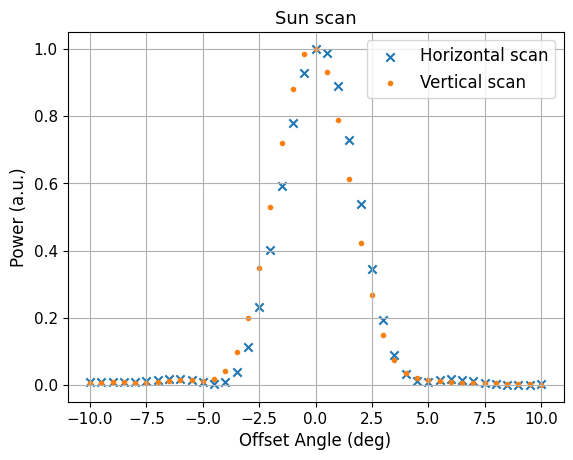

In [41]:
pt.plotting.start_plot('Sun scan', 'Offset Angle (deg)', 'Power (a.u.)')
plot_sun_scan('Measurements/SunScan/SunScan_Az10deg_Res0deg5_T1120_20251002.hdf',
              'Measurements/SunScan/SunScan_Elv10deg_Res0deg5_T1120_20251002.hdf')
pt.plotting.end_plot()


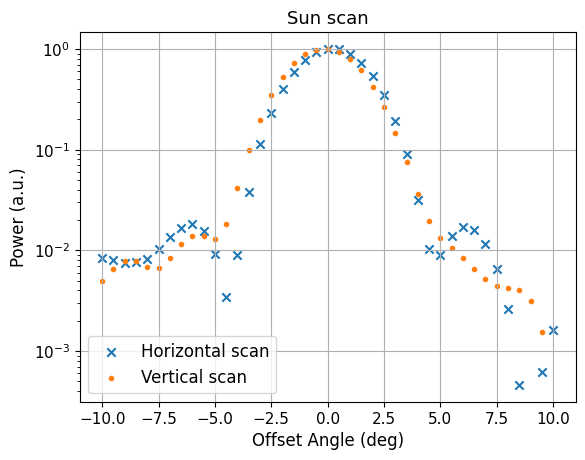

In [42]:
pt.plotting.start_plot('Sun scan', 'Offset Angle (deg)', 'Power (a.u.)')
plot_sun_scan('Measurements/SunScan/SunScan_Az10deg_Res0deg5_T1120_20251002.hdf',
              'Measurements/SunScan/SunScan_Elv10deg_Res0deg5_T1120_20251002.hdf')
plt.yscale('log')
pt.plotting.end_plot()

the assymetry in the vertical part of the scan might be due to antenna symmetry, maybe the topmost of the three connecting rods